# STAT435 - HW4

### Instructor: Professor Bradly Stadie
### Due Date: Nov 11, Monday
### Office Hour (Young): Wednesdays 1:30-2:30pm

In this homework, we will explore several concepts using some different environments. In particular, 
- we will study *exploration* in mountatin car (discrete)
- we will study offline RL in FrozenLake

In [1]:
#Dependencies

import gymnasium as gym
import torch
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import deque, namedtuple
import pickle
import time

## 1. Exploration

Now, we study various exploration strategies. In this problem, we will use the mountain car environment and solve the environment with Q-learning. One issue with this approach is that the environment has a continuous state. So if we want to use Q-learning, we will have to discretize the state space.

We also make another adjustment to Q-learning. We want to give exploration bonus to the states not visited frequently enough. This idea of exploration bonus is implemented in the BonusGiver class. Some interesting paper on exploration bonus on Q-learning (https://arxiv.org/abs/1901.09311).

1. complete the bonus giver class. Since the state space is continuous, we want to discretize the space into 25 bins, and give bonus according to the bins.

In [7]:
class BonusGiver:
    def __init__(self, env):
        self.high = env.observation_space.high
        self.low = env.observation_space.low
        self.n_visits = dict()
        self.num_bins = 25

    def discretize_state(self, state):
        #Discretize the state space and return the tuple of bins
        #note that the mountain car has 2-dim observation space
        # Create bins for each dimension
        bins_pos = np.linspace(self.low[0], self.high[0], self.num_bins)
        bins_vel = np.linspace(self.low[1], self.high[1], self.num_bins)
        
        # Digitize each dimension to get bin indices
        pos_bin = np.digitize(state[0], bins_pos)
        vel_bin = np.digitize(state[1], bins_vel)
        
        # Return tuple of discretized state
        discrete_state = (pos_bin, vel_bin)
        return discrete_state

    def get_bonus(self, state):
        #return visitation bonus on the bin the state belongs to
        beta = 10
        
        # Discretize the state into bins
        discrete_state = self.discretize_state(state)
        
        # If we haven't seen this state before, initialize visit count to 0
        if discrete_state not in self.n_visits:
            self.n_visits[discrete_state] = 0
            
        # Increment visit count for this state
        self.n_visits[discrete_state] += 1
        
        # Calculate exploration bonus - higher for less visited states
        # Using 1/sqrt(N) type bonus as common in literature
        bonus = beta / np.sqrt(self.n_visits[discrete_state])
        
        return bonus
        

2. complete the Q-learning agent class. (NOTE that this is NOT a DQN agent)

In [8]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon = 0.2):
        self.env = env
        self.bonus_giver = BonusGiver(env)

        #Initialize the trainig parameters
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

        # For mountain car, state space is discretized into 25x25 bins (from BonusGiver)
        self.num_bins = self.bonus_giver.num_bins
        self.num_states = (self.num_bins, self.num_bins)  # Position and velocity bins
        self.num_actions = env.action_space.n  # Number of discrete actions
        # Initialize Q-table with zeros - shape is (25, 25, num_actions)
        # Initialize Q-table with zeros - shape is (25, 25, num_actions)
        # num_states is a tuple of (num_bins, num_bins), need to concatenate with num_actions
        q_table_shape = self.num_states + (self.num_actions,)
        self.q_table = np.zeros(q_table_shape)

    def select_action(self, state, greedy = True):
        # Discretize state using BonusGiver's discretization
        discrete_state = self.bonus_giver.discretize_state(state)
        
        # Get Q-values for current state
        q_values = self.q_table[discrete_state[0], discrete_state[1]]
        
        if greedy:
            # Select action with highest Q-value
            action = np.argmax(q_values)
        else:
            # Epsilon-greedy action selection
            if np.random.random() < self.epsilon:
                action = self.env.action_space.sample()  # Random action
            else:
                action = np.argmax(q_values)  # Greedy action
        
        return action

    def update_model(self, state, action, next_state, reward):
        # Discretize current and next states
        discrete_state = self.bonus_giver.discretize_state(state)
        discrete_next_state = self.bonus_giver.discretize_state(next_state)
        
        # Get current Q-value using proper indexing
        current_q = self.q_table[discrete_state[0], discrete_state[1], action]
        
        # Get max Q-value for next state
        next_q_values = self.q_table[discrete_next_state[0], discrete_next_state[1]]
        next_max_q = np.max(next_q_values)
        
        # Q-learning update rule
        # Q(s,a) = Q(s,a) + alpha * (reward + gamma * max(Q(s',a')) - Q(s,a))
        new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
        
        # Update Q-table with proper indexing
        self.q_table[discrete_state[0], discrete_state[1], action] = new_q

In [6]:
a = np.zeros((100,100) + (50,))
print(a.shape)

(100, 100, 50)


3. Complete the train function and see how the policy behaves. First, compare $\epsilon$-greedy Q-learning and **greedy** Q-learning with exploration bonus. How do they compare? Is giving a bonus enough for exploration?

In [13]:
def train(episodes=30000, epsilon_greedy=True, use_bonus=True):
    """
    Train Q-learning agent with different exploration strategies
    Args:
        episodes: Number of training episodes
        epsilon_greedy: If True, use epsilon-greedy exploration, if False use greedy
        use_bonus: If True, add exploration bonus to rewards
    """
    env_id = "MountainCar-v0"  # Changed to discrete version
    env = gym.make(env_id)
    #the default maximum episode length of 200 is not enough to learn, so I increased the max episode length
    env._max_episode_steps = 1000
    
    agent = QLearningAgent(env)
    bonus_giver = BonusGiver(env)
    
    scores_history = []
    step_history = []
    successes = [] 
    
    for _ in tqdm(range(0, episodes)):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        step = 0

        while not done:
            # Get action from agent based on exploration strategy
            action = agent.select_action(state, greedy=not epsilon_greedy)
            
            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Add exploration bonus if enabled
            if use_bonus:
                reward += bonus_giver.get_bonus(state)
            
            # Update Q-values
            agent.update_model(state, action, next_state, reward)
            
            # Update metrics
            ep_reward += reward
            step += 1
            state = next_state
            
            if terminated:
                successes.append(1)
            elif truncated:
                successes.append(0)
        
        scores_history.append(ep_reward)
        step_history.append(step)
    
    env.close()

    return agent, scores_history, step_history

In [14]:
def plot_Q_learning(scores_history, step_history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(scores_history)), scores_history, label='Sum of Episode Rewards')
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(step_history)), step_history, label='Episode Length')
    plt.title('Episode Lengths')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
e_agent, e_scores_history, e_step_history = train(use_bonus=False)

100%|██████████| 30000/30000 [06:59<00:00, 71.54it/s]


In [17]:
g_agent, g_scores_history, g_step_history = train(epsilon_greedy=False)

100%|██████████| 30000/30000 [07:39<00:00, 65.23it/s]


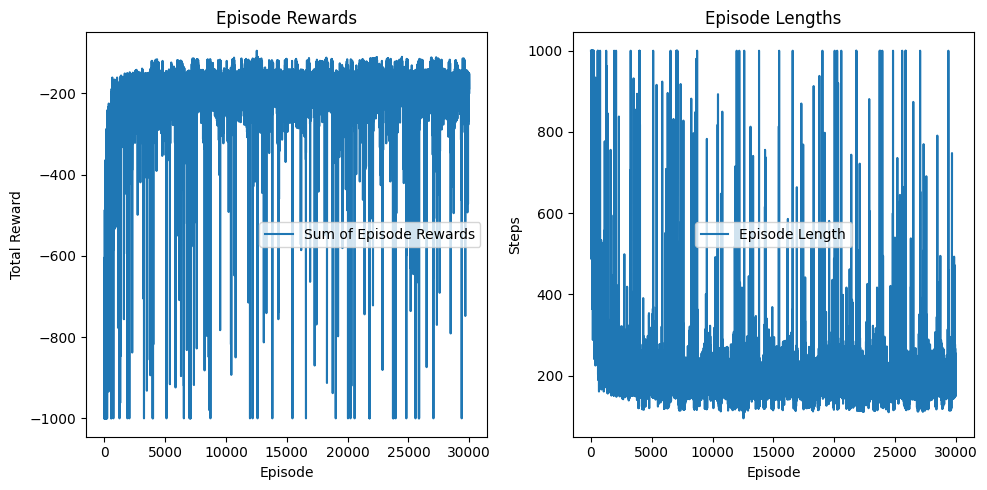

In [16]:
plot_Q_learning(e_scores_history, e_step_history)

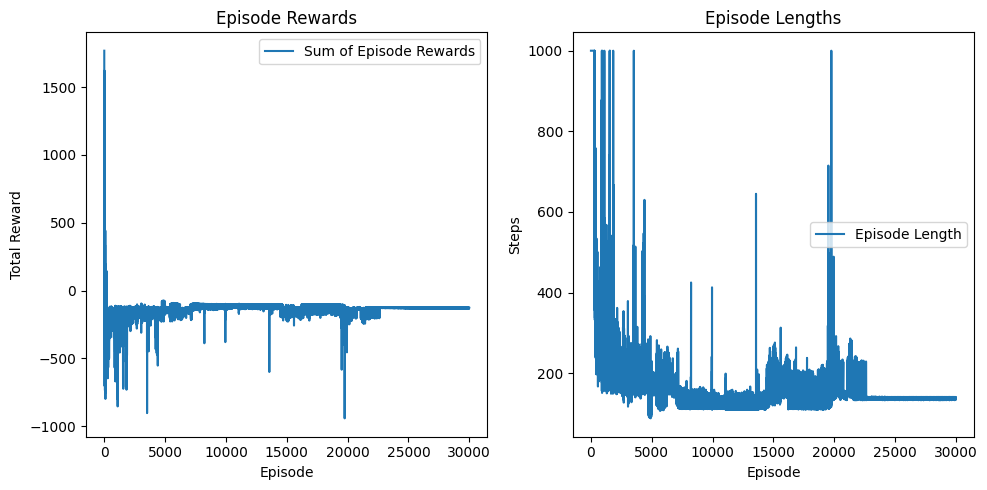

In [18]:
plot_Q_learning(g_scores_history, g_step_history)

Giving reward bonus really help to stablize the training procedure, and make the performance better (shorter episode length, larger total reward) after enough training epochs. However, giving a bonus is not enough for exploration, even in this simple environment. Sometimes you might get stuck in some small "loops" of state collections. Besides, it's hard to define the constant (C/n(s)), this should depend on the reward of each state. If it's not well chosen, the bonus reward will never encourage the exploration, as the original reward will dominate the total reward.

4. Now, try $\epsilon$-greedy Q-learning with exploration bonus. How does it perform and why?

In [19]:
eg_agent, eg_score_history, eg_step_history = train()

100%|██████████| 30000/30000 [09:23<00:00, 53.24it/s]


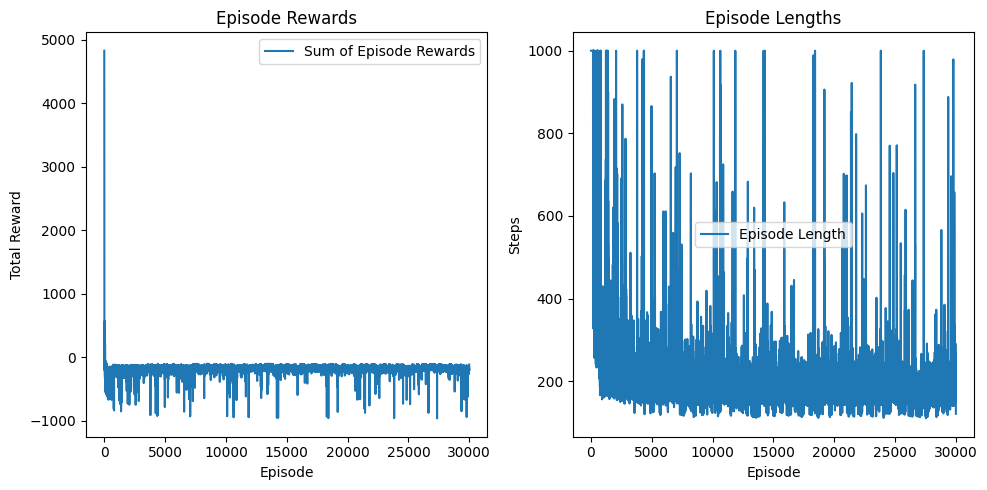

In [20]:
plot_Q_learning(eg_score_history, eg_step_history)

Combine the two exploration strategies together, we can see that: (1) Compare to the epsilon-greedy agent, the variance of total reward is much smaller, which means the training procedure is more stable. This is intuitively because that bonus reward tries to implicitly encourage the agent to explore more unseen states, and this process is smooth (with a 1/n(s) bonus reward) while epsilon-greedy agent will simply choose a random action with probability epsilon, and reach some other unseen states, which makes the agent puzzled to choose the next action. This leads to a larger variance during training. (2) Compare to agent with pure bonus reward to encourage exploration, we can see that the training process is even more stable according to the total reward. Besides, the episode length is shorter than the agent using both strategies after enough training epochs. However, from the next question (question 5), we can see that combining the two strategies together is still kind of helpful to the agent performance.

5. Run simulation from the learned policies, then get average number of steps and average number of successes for each agent.

In [22]:
def simulate_policy(agent, num_episodes=100):
    """
    Run simulation using learned policy and return average steps and success rate
    
    Args:
        agent: Trained Q-learning agent
        num_episodes: Number of episodes to simulate
        
    Returns:
        avg_steps: Average number of steps per episode
        success_rate: Fraction of episodes that reached the goal
    """
    env = gym.make('MountainCar-v0')
    total_steps = 0
    successes = 0
    
    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()  # Reset returns (state, info) in newer gym versions
        done = False
        steps = 0
        
        while not done:
            action = agent.select_action(state, greedy=True)  # Use greedy policy for evaluation
            next_state, reward, terminated, truncated, _ = env.step(action)  # Newer gym step returns 5 values
            done = terminated or truncated
            state = next_state
            steps += 1
            
            # Success in MountainCar is reaching the flag (position > 0.5)
            if terminated and state[0] >= 0.5:  # Check if car reached the goal
                successes += 1
                
        total_steps += steps
        
    avg_steps = total_steps / num_episodes
    success_rate = successes / num_episodes
    
    env.close()
    return avg_steps, success_rate

# Run simulation for each agent
e_steps, e_success = simulate_policy(e_agent)
g_steps, g_success = simulate_policy(g_agent) 
eg_steps, eg_success = simulate_policy(eg_agent)

print("Epsilon-greedy agent:")
print(f"Average steps: {e_steps:.2f}")
print(f"Success rate: {e_success:.2%}\n")

print("Greedy agent:")
print(f"Average steps: {g_steps:.2f}") 
print(f"Success rate: {g_success:.2%}\n")

print("Epsilon-greedy with bonus agent:")
print(f"Average steps: {eg_steps:.2f}")
print(f"Success rate: {eg_success:.2%}")

100%|██████████| 100/100 [00:00<00:00, 307.10it/s]

Epsilon-greedy agent:
Average steps: 143.68
Success rate: 100.00%

Greedy agent:
Average steps: 137.91
Success rate: 100.00%

Epsilon-greedy with bonus agent:
Average steps: 120.50
Success rate: 100.00%


As we can see in the result, The pure epsilon-greedy agent performs the worst with the biggest average steps, pure greedy agent with bonus reward for exploration is a little bit better than epsilon-greedy agent. If we combine the two exploration strategies together (explicitly and implicitly), the performance improve additionally, but not that much. This means that both epsilon-greedy and bonus reward can help with exploration, which will reduce the overestimation problem. Besides, all the three agents achieve success rate of 100 percent, meaning that they can solve this environment with simple exploration strategies, so that the environment itself is not a hard one. 

## 2. Conservative Q-Learning

In this problem, we will explore offline RL vs. online RL, using FrozenLake environment. In particular, we will use DQN and CQL, and compare how they perform in the environment.

1. Implement offline DQN and run it on FrozenLake. Note that we are implementing **offline** DQN. i.e. we do not have access to the environment (and that of course means no saving data point to the buffer). You will be given a simulated expert data (policy trained on PPO) that you will use to train.
2. Implement CQL and run it on FrozenLake

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The following datatype will be needed to use the data given to you.

In [24]:
Experience = namedtuple("Experience", ["state", "action", "next_state", "reward", "done"])

1. Implement Q network you will train! (You can either define one-hot vectorizing function or use the nn.Embedding layer for taking the input.)

In [25]:
class QFunctionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, use_embedding=True):
        super(QFunctionNet, self).__init__()
        
        if use_embedding:
            # Embedding approach
            self.embedding = nn.Embedding(input_size, hidden_size)
            self.net = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            )
        else:
            # One-hot encoding approach
            self.net = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            )
        
        self.use_embedding = use_embedding

    def forward(self, x):
        if self.use_embedding:
            # For embedding approach, input should be tensor of indices
            x = self.embedding(x)
            out = self.net(x)
        else:
            # For one-hot approach, input should already be one-hot encoded
            out = self.net(x)
        
        return out

2. Now implement a replay buffer. THIS IS NOT the buffer you will need. We are just loading the data to the buffer to use during training.

In [26]:
class ReplayBuffer:
    def __init__(self, batch_size):
        self.memory = []  # Initialize empty list to store experiences
        self.batch_size = batch_size  # Size of batch to sample
        
    def load_dataset(self, filepath = './ppo_expert_data.pkl'):
        # Load dataset from pickle file
        with open(filepath, 'rb') as f:
            self.memory = pickle.load(f)
        print(f"Dataset loaded with {len(self.memory)} transitions.")

    def sample(self):
        # Randomly sample a batch from the memory
        experiences = random.sample(self.memory, self.batch_size)
        
        # Unzip the experiences into separate arrays
        states = torch.tensor([e.state for e in experiences], dtype=torch.long).to(device)
        actions = torch.tensor([e.action for e in experiences], dtype=torch.long).to(device)
        rewards = torch.tensor([e.reward for e in experiences], dtype=torch.float).to(device)
        next_states = torch.tensor([e.next_state for e in experiences], dtype=torch.long).to(device)
        dones = torch.tensor([e.done for e in experiences], dtype=torch.float).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)


3. Now implement your DQN agent. Unlike from HW2, we will be implementing a DQN agent that utilizes two q-functions (target network and update network). If you are interested why this actually is a good trick, read this paper (https://www.nature.com/articles/nature14236). We will use the hard update rule (simply load the parameter to the target network)

In [39]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size=128, gamma=0.99, lr=1e-3):
        # Parameters about environment
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        
        # Parameters for training
        self.gamma = gamma
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Define the Q-networks and optimizer
        hidden_size = 128
        self.qnetwork = QFunctionNet(state_size, hidden_size, action_size).to(self.device)
        self.target_network = QFunctionNet(state_size, hidden_size, action_size).to(self.device)
        self.optimizer = torch.optim.Adam(self.qnetwork.parameters(), lr=self.lr)
        
        # Replay buffer
        self.memory = ReplayBuffer(batch_size)
        
        # Initialize target network with same weights
        self.load_weight()

    def learn(self, experiences, conservative=False):
        states, actions, rewards, next_states, dones = experiences
        
        with torch.no_grad():
            # Get next state values from target network
            next_q_values = self.target_network(next_states)
            next_q_values_max = next_q_values.max(1)[0].unsqueeze(1)
            # Compute target Q values
            q_targets = rewards.unsqueeze(1) + (self.gamma * next_q_values_max * (1 - dones.unsqueeze(1)))
        
        # Get current Q values from local network
        all_q_values = self.qnetwork(states)  # Get all Q-values before gathering
        q_values = all_q_values.gather(1, actions.unsqueeze(1))
        
        # Compute loss
        loss = nn.MSELoss()(q_values, q_targets)
        
        if conservative:
            # Add CQL loss if conservative learning is enabled
            # Pass all Q-values instead of gathered Q-values
            cql_loss = self.cql_loss(all_q_values, actions)
            loss += cql_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss

    def cql_loss(self, q_values, current_action):
        """
        Compute CQL loss using all Q-values and current actions
        Args:
            q_values: Q-values for all actions [batch_size, num_actions]
            current_action: Selected actions [batch_size]
        """
        alpha = 1.0  # CQL regularization parameter
        
        # Compute logsumexp of Q-values across action dimension
        q_logsumexp = torch.logsumexp(q_values, dim=1, keepdim=True)  # [batch_size, 1]
        
        # Get Q-values for current actions
        q_chosen = q_values.gather(1, current_action.unsqueeze(1))  # [batch_size, 1]
        
        # CQL loss is the difference between logsumexp of all actions and Q-value of chosen action
        cql_loss = (q_logsumexp - q_chosen).mean() * alpha
        
        return cql_loss

    def act(self, state):
        # Convert state to tensor and get Q-values
        state = torch.tensor([state], dtype=torch.long).to(self.device)
        
        with torch.no_grad():
            q_values = self.qnetwork(state)
        
        # Choose action with highest Q-value
        best_action = q_values.argmax(1).item()
        
        return best_action

    def forward(self, state):
        return self.qnetwork(state)
    
    def load_weight(self):
        # Hard update: Copy weights from update network to target network
        self.target_network.load_state_dict(self.qnetwork.state_dict())

You can use the training codes below to train you agent.

In [34]:
def train_offline_dqn(agent, n_epochs=50, running_loss_length=10, conservative = False):
    losses = []
    running_losses = []
    data_size = agent.memory.__len__()
    batch_size = agent.batch_size
    successes = []

    env = gym.make("FrozenLake-v1")

    for epoch in tqdm(range(1, n_epochs + 1)):
        epoch_losses = []
        # Sample experiences from the offline dataset
        for i in range(int(data_size/batch_size)):
            experiences = agent.memory.sample()
            loss = agent.learn(experiences, conservative)
            epoch_losses.append(loss.item())
        
        if epoch % 5 == 0:
            agent.load_weight()

        done = False
        trun = False
        s, _ = env.reset()

        # Run simulation to check success rate
        # continue if not done or trun
        while not done and not trun:
            action = agent.act(s)
            next_s, r, done, trun, _ = env.step(action)
            s = next_s

            if done and r ==1:
                successes.append(r)

        avg_epoch_loss = np.mean(epoch_losses)
        losses.append(avg_epoch_loss)

        running_loss = np.mean(losses[-running_loss_length:])
        running_losses.append(running_loss)

        if epoch % 5 == 0:
            print(f"Epoch {epoch}|Success Rate: {np.sum(successes)/epoch}  | Loss: {avg_epoch_loss:.4f} | Running Loss: {running_loss:.4f}")

    return losses, running_losses

In [35]:
def train(conservative = False):
    # Specify state_size and action_size based on your environment
    state_size = 16  # Adjust based on your dataset's state representation
    action_size = 4  # Adjust based on your dataset's action space
    batch_size = 256

    # Initialize agent
    agent = DQNAgent(state_size, action_size, batch_size=batch_size)

    # Load the offline dataset generated by PPO (path to your .pkl file)
    dataset_path = "./ppo_expert_data.pkl"
    agent.memory.load_dataset(dataset_path)


    # Train with running reward tracking
    losses, running_losses = train_offline_dqn(agent, n_epochs=100, conservative = conservative)

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Loss", alpha=0.6)
    plt.plot(running_losses, label="Running Loss", color='orange', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss and Running Loss per Epoch')
    plt.legend()
    plt.show()

    return agent

Dataset loaded with 100000 transitions.


  5%|▌         | 5/100 [00:03<00:57,  1.65it/s]

Epoch 5|Success Rate: 0.2  | Loss: 0.0344 | Running Loss: 0.0350


 10%|█         | 10/100 [00:06<00:56,  1.59it/s]

Epoch 10|Success Rate: 0.1  | Loss: 0.0118 | Running Loss: 0.0234


 15%|█▌        | 15/100 [00:09<00:54,  1.55it/s]

Epoch 15|Success Rate: 0.13333333333333333  | Loss: 0.0113 | Running Loss: 0.0115


 20%|██        | 20/100 [00:12<00:53,  1.49it/s]

Epoch 20|Success Rate: 0.1  | Loss: 0.0112 | Running Loss: 0.0112


 25%|██▌       | 25/100 [00:16<00:52,  1.43it/s]

Epoch 25|Success Rate: 0.08  | Loss: 0.0097 | Running Loss: 0.0105


 30%|███       | 30/100 [00:19<00:50,  1.39it/s]

Epoch 30|Success Rate: 0.13333333333333333  | Loss: 0.0095 | Running Loss: 0.0096


 35%|███▌      | 35/100 [00:23<00:47,  1.37it/s]

Epoch 35|Success Rate: 0.11428571428571428  | Loss: 0.0079 | Running Loss: 0.0087


 40%|████      | 40/100 [00:27<00:44,  1.34it/s]

Epoch 40|Success Rate: 0.2  | Loss: 0.0081 | Running Loss: 0.0080


 45%|████▌     | 45/100 [00:31<00:41,  1.31it/s]

Epoch 45|Success Rate: 0.2  | Loss: 0.0084 | Running Loss: 0.0082


 50%|█████     | 50/100 [00:34<00:38,  1.30it/s]

Epoch 50|Success Rate: 0.24  | Loss: 0.0078 | Running Loss: 0.0081


 55%|█████▌    | 55/100 [00:38<00:35,  1.28it/s]

Epoch 55|Success Rate: 0.23636363636363636  | Loss: 0.0080 | Running Loss: 0.0080


 60%|██████    | 60/100 [00:42<00:31,  1.29it/s]

Epoch 60|Success Rate: 0.23333333333333334  | Loss: 0.0082 | Running Loss: 0.0081


 65%|██████▌   | 65/100 [00:46<00:27,  1.27it/s]

Epoch 65|Success Rate: 0.23076923076923078  | Loss: 0.0076 | Running Loss: 0.0078


 70%|███████   | 70/100 [00:50<00:23,  1.29it/s]

Epoch 70|Success Rate: 0.22857142857142856  | Loss: 0.0071 | Running Loss: 0.0073


 75%|███████▌  | 75/100 [00:54<00:19,  1.29it/s]

Epoch 75|Success Rate: 0.22666666666666666  | Loss: 0.0070 | Running Loss: 0.0071


 80%|████████  | 80/100 [00:58<00:15,  1.30it/s]

Epoch 80|Success Rate: 0.2125  | Loss: 0.0073 | Running Loss: 0.0072


 85%|████████▌ | 85/100 [01:02<00:11,  1.30it/s]

Epoch 85|Success Rate: 0.21176470588235294  | Loss: 0.0068 | Running Loss: 0.0071


 90%|█████████ | 90/100 [01:05<00:07,  1.30it/s]

Epoch 90|Success Rate: 0.2222222222222222  | Loss: 0.0069 | Running Loss: 0.0068


 95%|█████████▌| 95/100 [01:09<00:03,  1.30it/s]

Epoch 95|Success Rate: 0.22105263157894736  | Loss: 0.0068 | Running Loss: 0.0068


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]

Epoch 100|Success Rate: 0.22  | Loss: 0.0064 | Running Loss: 0.0066


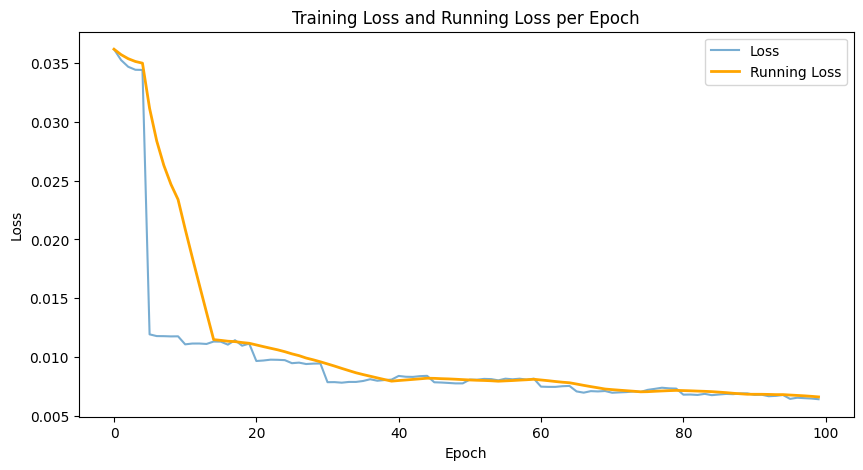

In [36]:
agent = train()

Now, evaluate how this learned agent performs in the environment.

In [40]:
def simulate(agent, simulate_n = 100, render_episode = True):
    env = gym.make('FrozenLake-v1')

    episode_lengths = []
    episode_rewards = []
    successes = 0

    for _ in range(simulate_n):
        state, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        steps = 0

        while not done and not truncated:
            action = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1
            state = next_state

            if done:
                if reward == 1:
                    successes +=1
                episode_lengths.append(steps)
                episode_rewards.append(total_reward)

    avg_episode_length = np.mean(episode_lengths)
    avg_reward = np.mean(episode_rewards)
    success_rates = successes / simulate_n

    print(f"Average Episode Length: {avg_episode_length}")
    print(f"Average Reward: {avg_reward}")
    print(f"Success Rate: {success_rates * 100:.2f}%")

    return avg_episode_length, avg_reward, success_rates

def visual_simulation(agent):
    env = gym.make("FrozenLake-v1", render_mode = "human")
    state, _ = env.reset()
    done = False
    trun = False
    env.render()

    while not done and not trun:
        action = agent.act(state)
        next_state, _, done, trun, _ = env.step(action)
        state = next_state
        env.render()

    env.close()

In [42]:
dqn_avg_episode_length, dqn_avg_reward, dqn_success_rates = simulate(agent)

Average Episode Length: 15.64
Average Reward: 0.16
Success Rate: 16.00%


4. How does offline DQN perform in the frozen lake environment? Why do you think this is happening?

The performance is not good. I think the main reason is the overestimation problem. Specifically, only those state in the dataset can be learned correctly (reasonable Q value). The other unseen states will be overestimated, and this problem will getting more severe with more training epochs. That's probably the reason that the success rate will decrease a little bit after too many training epochs.

5. Now, go back up and implement a Conservative Q-Learning Agent. You only have to fix couple lines. Read this paper (https://arxiv.org/pdf/2006.04779), equation (4)

Dataset loaded with 100000 transitions.


  5%|▌         | 5/100 [00:03<01:01,  1.54it/s]

Epoch 5|Success Rate: 0.8  | Loss: 0.1808 | Running Loss: 0.1908


 10%|█         | 10/100 [00:06<00:58,  1.54it/s]

Epoch 10|Success Rate: 0.9  | Loss: 0.1778 | Running Loss: 0.1833


 15%|█▌        | 15/100 [00:09<00:55,  1.52it/s]

Epoch 15|Success Rate: 0.8  | Loss: 0.1702 | Running Loss: 0.1751


 20%|██        | 20/100 [00:13<00:53,  1.49it/s]

Epoch 20|Success Rate: 0.75  | Loss: 0.1733 | Running Loss: 0.1750


 25%|██▌       | 25/100 [00:16<00:51,  1.46it/s]

Epoch 25|Success Rate: 0.72  | Loss: 0.1730 | Running Loss: 0.1762


 30%|███       | 30/100 [00:20<00:49,  1.42it/s]

Epoch 30|Success Rate: 0.7  | Loss: 0.1785 | Running Loss: 0.1783


 35%|███▌      | 35/100 [00:23<00:46,  1.38it/s]

Epoch 35|Success Rate: 0.7142857142857143  | Loss: 0.1727 | Running Loss: 0.1785


 40%|████      | 40/100 [00:27<00:43,  1.37it/s]

Epoch 40|Success Rate: 0.7  | Loss: 0.1737 | Running Loss: 0.1763


 45%|████▌     | 45/100 [00:31<00:41,  1.31it/s]

Epoch 45|Success Rate: 0.6666666666666666  | Loss: 0.1725 | Running Loss: 0.1741


 50%|█████     | 50/100 [00:35<00:38,  1.31it/s]

Epoch 50|Success Rate: 0.68  | Loss: 0.1680 | Running Loss: 0.1727


 55%|█████▌    | 55/100 [00:38<00:34,  1.30it/s]

Epoch 55|Success Rate: 0.6909090909090909  | Loss: 0.1775 | Running Loss: 0.1728


 60%|██████    | 60/100 [00:42<00:30,  1.29it/s]

Epoch 60|Success Rate: 0.6833333333333333  | Loss: 0.1749 | Running Loss: 0.1740


 65%|██████▌   | 65/100 [00:46<00:27,  1.27it/s]

Epoch 65|Success Rate: 0.6923076923076923  | Loss: 0.1743 | Running Loss: 0.1736


 70%|███████   | 70/100 [00:50<00:23,  1.27it/s]

Epoch 70|Success Rate: 0.7  | Loss: 0.1678 | Running Loss: 0.1724


 75%|███████▌  | 75/100 [00:54<00:19,  1.27it/s]

Epoch 75|Success Rate: 0.6933333333333334  | Loss: 0.1773 | Running Loss: 0.1731


 80%|████████  | 80/100 [00:58<00:15,  1.25it/s]

Epoch 80|Success Rate: 0.6875  | Loss: 0.1660 | Running Loss: 0.1738


 85%|████████▌ | 85/100 [01:02<00:12,  1.24it/s]

Epoch 85|Success Rate: 0.6941176470588235  | Loss: 0.1636 | Running Loss: 0.1721


 90%|█████████ | 90/100 [01:06<00:08,  1.23it/s]

Epoch 90|Success Rate: 0.7  | Loss: 0.1642 | Running Loss: 0.1707


 95%|█████████▌| 95/100 [01:11<00:04,  1.17it/s]

Epoch 95|Success Rate: 0.7052631578947368  | Loss: 0.1666 | Running Loss: 0.1690


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]

Epoch 100|Success Rate: 0.71  | Loss: 0.1646 | Running Loss: 0.1687


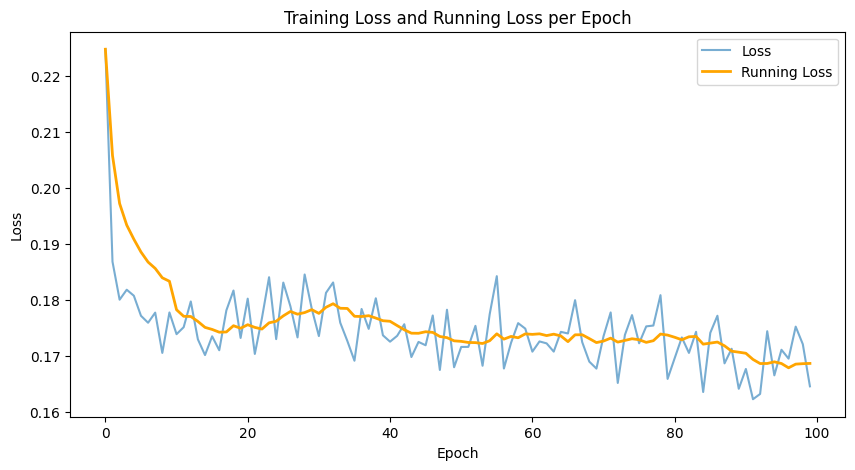

In [41]:
cql_agent = train(conservative=True)

In [43]:
cql_avg_episode_length, cql_avg_reward, cql_success_rates = simulate(cql_agent)

Average Episode Length: 39.08247422680412
Average Reward: 0.7938144329896907
Success Rate: 77.00%


6. How does CQL perform compared to offline DQN? why do you think this is so?


CQL performs better than offline DQN because it explicitly addresses the overestimation problem in offline settings through its conservative loss term. While standard DQN only minimizes the TD error $(r + \gamma \max_{a'} Q(s', a') - Q(s,a))^2$, CQL adds a regularization term $\alpha(\log \sum_a \exp(Q(s,a)) - Q(s,a_{\text{data}}))$ that penalizes high Q-values for out-of-distribution actions. This additional term effectively "pushes down" Q-values for all actions through the $\log \sum_a \exp(Q(s,a))$ term while "pulling up" Q-values for actions seen in the dataset through $-Q(s,a_{\text{data}})$. As a result, CQL achieves a higher success rate (0.7 vs 0.2) and more stable training by learning a conservative value function that better reflects the true value of actions demonstrated in the offline dataset.